# Explainable AI with Linked Statistical Data
In our case, the 2011 Data Zones are employed as the geographical unit of analysis for the case study. Data zones are the core geography for dissemination of results from Scottish Neighborhood Statistics. They are designed to have roughly standard populations of 500 to 1,000 household residents. There are 6,976 2011 Data Zones.

The topic that will be explored is the population being prescribed drugs for anxiety, depression or psychosis in the 2011 Data Zones in the year 2017. The average of this indicator in 2017 across the 6,976 data zones is 18.6477, while the median is 18.28. The problem that will be explored is the prediction of the probability the population being prescribed drugs for anxiety, depression or psychosis of a datazone is higher than the average 18.6477. Moreover, what are the factors that contribute towards this prediction in each data zone.

eXtreme Gradient Boosting (XGBoost) is used to create the predictive model and SHapley Additive exPlanation (SHAP) framework to explain the predictive model.

In [ ]:
# !pip install shap

In [ ]:
#Connect to the Google Driver
from google.colab import drive
# Extras
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

In [ ]:
import shap
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib
matplotlib.use('Agg')
matplotlib.style.use('ggplot')
from numpy import mean
from numpy import sort
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

## **The Dataset**

In order to solve the specified problem, compatible datasets that can be exploited are collected from the Scottish open data portal. Towards this end, two criteria are specified: (a) the dataset includes data for 2017 as the year of reference, and (b) the dataset includes data at the granularity level of 2011 data zones. 

Because the available data have been shaped as Linked Data, a SPARQL query is structured in order to formally specify these criteria.

The results of the query have been saved at a CSV file

### **Target** 
- Binary variable indicating whether thepopulation being prescribed drugs for anxiety, depression or psychosis of a data zone is higher than the average 18.6477.

### **Features** 
- Mean house price of a data zone
- Number of house sales
- Number of dwellings per hectare
- Number of flats
- Percentage of flats
- Median number of rooms in dwellings
- Number of dwellings
- Percentage of total dwellings that are long empty
- Percentage of total dwellings that are occupied
- Percentage of total dwellings that are second homes
- Percentage of population living proxime to derelict site
- Scottish access to bus indicator (weekday)
- Scottish access to bus indicator (weekend)
- Number of births
- Number of deaths
- Mid-year population estimates
- Number of families receiving child benefit
- Number of children receiving child benefit
- Comparative illness factor
- Standardised mortality ratio
- Hospital stays related to alcohol misuse: standardized ratio
- The number of people who are employment deprived
- The percentage of people who are employment deprived


## **1. Getting to know our data**

Let's get to know our columns and split our data into features and labels!

In [ ]:
#The CSV file includes Data from the SPARQL query
df=pd.read_csv('/content/drive/MyDrive/Colab_projects/Web Analytics/sparql_2017.csv')

In [ ]:
df.columns

Index(['area', 'price17', 'sales17', 'births17', 'busscore17',
       'busscoreweekend17', 'derelictall17', 'childbenefit17',
       'familiesbenefit17', 'popall17', 'death17', 'occup17', 'longempty17',
       'sechomes17', 'totaldwel17', 'ill17', 'depr17', 'alco17', 'mortality17',
       'unempl17', 'unempcountl17', 'flatsratio17', 'flatscount17', 'rooms17',
       'hectare17'],
      dtype='object')

We change the names of the columns to be self-explaining 

In [ ]:
df = df.rename(columns = {'sales17':'HouseSales', 'births17':'Births', 'busscore17':'BusAccessibility(weekday)', 'busscoreweekend17':'BusAccessibility(weekend)', 'derelictall17':'DerelictPopulation', 'childbenefit17':'Children_ChildBenefits', 'familiesbenefit17':'Families_ChildBenefits', 'popall17':'Population', 'death17':"NumberofDeaths", 'occup17':'OccupiedDwellings', 'longempty17':'LongEmptyDwellings', 'sechomes17':'SecondHomes', 'totaldwel17':'TotalDwellings', 'ill17':'ComparativeIllnessFactor', 'depr17':'Anxiety/Depression', 'alco17':'AlcoholMisuse', 'mortality17':'StandarizedMortalityRatio', 'unempl17':'EmploymentDeprived(Percentage)', 'unempcountl17':'EmploymentDeprived(count)', 'flatsratio17':'Flats(ratio)', 'flatscount17':'Flats(count)', 'rooms17':'RoomsinDwellings', 'hectare17':'DwellingsperHectar'})

In [ ]:
# List out our columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6140 entries, 0 to 6139
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   area                            6140 non-null   object 
 1   price17                         6140 non-null   int64  
 2   HouseSales                      6140 non-null   int64  
 3   Births                          6140 non-null   int64  
 4   BusAccessibility(weekday)       6140 non-null   float64
 5   BusAccessibility(weekend)       6140 non-null   float64
 6   DerelictPopulation              6140 non-null   float64
 7   Children_ChildBenefits          6140 non-null   int64  
 8   Families_ChildBenefits          6140 non-null   int64  
 9   Population                      6140 non-null   int64  
 10  NumberofDeaths                  6140 non-null   int64  
 11  OccupiedDwellings               6140 non-null   int64  
 12  LongEmptyDwellings              61

In [ ]:
# Take a closer look at column distributions
df.describe()

,price17,HouseSales,Births,BusAccessibility(weekday),BusAccessibility(weekend),DerelictPopulation,Children_ChildBenefits,Families_ChildBenefits,Population,NumberofDeaths,OccupiedDwellings,LongEmptyDwellings,SecondHomes,TotalDwellings,ComparativeIllnessFactor,Anxiety/Depression,AlcoholMisuse,StandarizedMortalityRatio,EmploymentDeprived(Percentage),EmploymentDeprived(count),Flats(ratio),Flats(count),RoomsinDwellings,DwellingsperHectar
count,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000
mean,167270.650489,14.042834,7.568404,23.300254,15.491011,28.332736,131.512215,80.004886,792.288762,8.437459,96.158632,1.356840,0.904886,379.717915,95.941368,18.647793,94.324024,96.570684,8.740717,43.580130,33.068958,141.980293,3.988762,19.854658
std,89164.833076,11.199066,5.247208,36.242719,24.892350,39.148988,58.738412,33.989137,220.783189,6.534096,3.965470,1.494801,2.647581,117.614841,51.561240,5.131275,89.947155,42.658083,6.354403,34.396431,31.880859,166.736531,0.893610,20.659015
min,22444.000000,5.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,337.000000,0.000000,41.000000,0.000000,0.000000,126.000000,5.000000,2.750000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,104531.500000,8.000000,4.000000,3.697500,2.350000,0.000000,90.000000,55.000000,651.000000,4.000000,95.000000,0.000000,0.000000,302.000000,55.000000,14.760000,33.355000,69.000000,4.000000,18.000000,5.575000,18.000000,3.000000,8.400000
50%,147210.000000,12.000000,7.000000,11.130000,7.230000,0.000000,125.000000,75.000000,768.000000,7.000000,97.000000,1.000000,0.000000,364.000000,85.000000,18.280000,68.015000,90.000000,7.000000,33.000000,22.600000,78.000000,4.000000,16.335000
75%,204755.500000,16.000000,10.000000,27.330000,17.940000,61.700000,160.000000,100.000000,898.000000,11.000000,98.000000,2.000000,1.000000,437.000000,130.000000,22.200000,125.720000,116.000000,12.000000,61.000000,54.300000,214.000000,5.000000,24.590000
max,888098.000000,188.000000,89.000000,487.390000,361.040000,100.000000,750.000000,495.000000,3847.000000,94.000000,100.000000,21.000000,54.000000,2103.000000,340.000000,38.380000,1656.370000,720.000000,43.000000,278.000000,100.000000,1870.000000,8.000000,219.230000


In [ ]:
# Create the target variable and save it as y
df['y'] = df['Anxiety/Depression'] > df['Anxiety/Depression'].mean()

# Remove the unnecessary variables 
df = df.drop(columns=['area','Anxiety/Depression'])

# Define X and y
X, y = df.drop('y', axis=1), df.y

## **2. Our First XGBoost Classifier**

XGBoost has a  [scikit-learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn), which is useful if you want to use different scikit-learn classes and methods on an XGBoost model (e.g.,`predict()`, `fit()`).  In this section, we'll try the API out with the `xgboost.XGBClassifier()` class and get a baseline accuracy for the rest of our work. So that our results are reproducible, we'll set the `random_state=123`.

As a reminder, gradient boosting sequentially trains weak learners where each weak learner tries to correct its predecessor's mistakes. First, we'll instantiate a simple XGBoost classifier without changing any of the other parameters, and we'll inspect the parameters that we haven't touched.

In [ ]:
# Train and test split using sklearn 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [ ]:
# Instatiate a XGBClassifier 
xgb_clf=xgb.XGBClassifier(random_state=123)

# Inspect the parameters
xgb_clf.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 123,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

There's a couple of things to note:
- The `booster` parameter is `gbtree`.  This means the weak learners, or boosters, are decision trees in this model. `gbtree` is the default, and we will keep it this way.
- The `objective` function, or loss function, is defined as `binary:logistic`. The objective function quantifies how far off a prediction is from the actual results. We want to minimize this to have the smallest possible loss. `binary:logistic` is the default for classifiers. `binary:logistic` outputs the actual predicted probability of the positive class (in our case, that a booking is cancelled).
- `n_estimators` is the number of gradient boosted trees we want in our model. It's equivalent to the number of boosting rounds. For our purposes, we don't want too many boosting rounds, or training will take too long.

<p align="center">
<img src="https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/assets/n_estimators.png?raw=true" width = "70%"> 
</p>

<br>

- `max_depth` is the maximum tree depth allowed. Tree depth is the length of the longest path from the root node to a leaf node. Making this too high will give our model more variance, or more potential to overfit. Similar to `n_estimators`, the more we increase this, the longer our training period will be. **Let's keep this at 3**.


<p align="center">
<img src="https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/assets/max_depth.png?raw=true" width = "25%"> 
</p>

- For our `eval_metric` (evaluation metric for validation data), we will use `error` as defined by [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/parameter.html):

> Binary classification error rate. It is calculated as #(wrong cases)/#(all cases). For the predictions, the evaluation will regard the instances with prediction value larger than 0.5 as positive instances, and the others as negative instances.

In [ ]:
## Set n_estimators to 150 
xgb_clf.set_params(n_estimators=150)

## Set max_depth to 3
xgb_clf.set_params(max_depth=3)

# Set the evaluation metric to error
xgb_clf.set_params(eval_metric='error')

XGBClassifier(eval_metric='error', n_estimators=150, random_state=123)

In [ ]:
# Fit it to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)
xgb_clf.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'eval_metric': 'error',
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 150,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 123,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

We are going to use **accuracy** as our metric for this problem since we only have two balanced classes. To calculate accuracy, we need to count the correctly predicted data points and divide it by the total number of data points.

In [ ]:
# Calculate the accuracy
accuracy = xgb_clf.score(X_test, y_test)

# Print the baseline accuracy
print("Baseline accuracy:", accuracy)

Baseline accuracy: 0.8736156351791531


## **3. Digging into Parameters**

There are many parameters for our tree booster. We can see this in the documentation for [parameters for tree booster](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster).

In this section, we'll take a look at several important parameters and understand what they do.

For this session's purpose, we'll use `XGBClassifier()`. 

Grid search and random search are the most popular methods for hyperparameter tuning. However, grid search can get computationally expensive if you are searching over a large hyperparameter space and dealing with multiple hyperparameters. Random search doesn't try all the hyperparameter values. In random search, a fixed number of hyperparameter settings is sampled from specified probability distributions.

In our case we will use Grid search because our data are quite small.

The `GridSearchCV()` function takes in the following arguments:

- `estimator`: The estimator being fit, here it's XGBoost.
- `param_grid`: The parameter grid to explore, as a dictionary mapping estimator parameters to sequences of allowed values.
- `cv`: Number of cross-validation iterations
- `verbose`: Prints more output

In [ ]:
paramGrid = {
         "learning_rate":[0.1, 0.15, 0.2],
         "n_estimators":[100, 150, 200, 300, 400],
         "max_depth": [3,4,5],
         "subsample": [0.5,0.8],
         "colsample_bytree": [0.6],
         "colsample_bylevel": [0.8]
            }  

# Insantiate XGBoost Clasifier
xgb_clf = XGBClassifier(eval_metric='error')

# Instantiate GridSearchCV()
gridsearch = GridSearchCV(estimator=xgb_clf, param_grid=paramGrid, cv=5, scoring='accuracy', verbose=1)

# Train the model on the training set
xgb_gs = gridsearch.fit(X_train, y_train)

# Print the best parameters and highest accuracy
print(xgb_gs.best_score_)
print(xgb_gs.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
0.8755700325732899
{'colsample_bylevel': 0.8, 'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [ ]:
xgb_gs.score(X_test, y_test)

0.8742671009771987

In [ ]:
#Getting the best model
best = xgb_gs.best_estimator_

In [ ]:
best

XGBClassifier(colsample_bylevel=0.8, colsample_bytree=0.6, eval_metric='error',
              n_estimators=200, subsample=0.8)

## **4. Global Explainability of the Model**

`XGBoost` has two handy visualization functions for interpreting results.

The first is `plot_importance()`  which plots feature importance, meaning, how predictive each feature is for the target variable. It takes in the fitted XGBoost model.

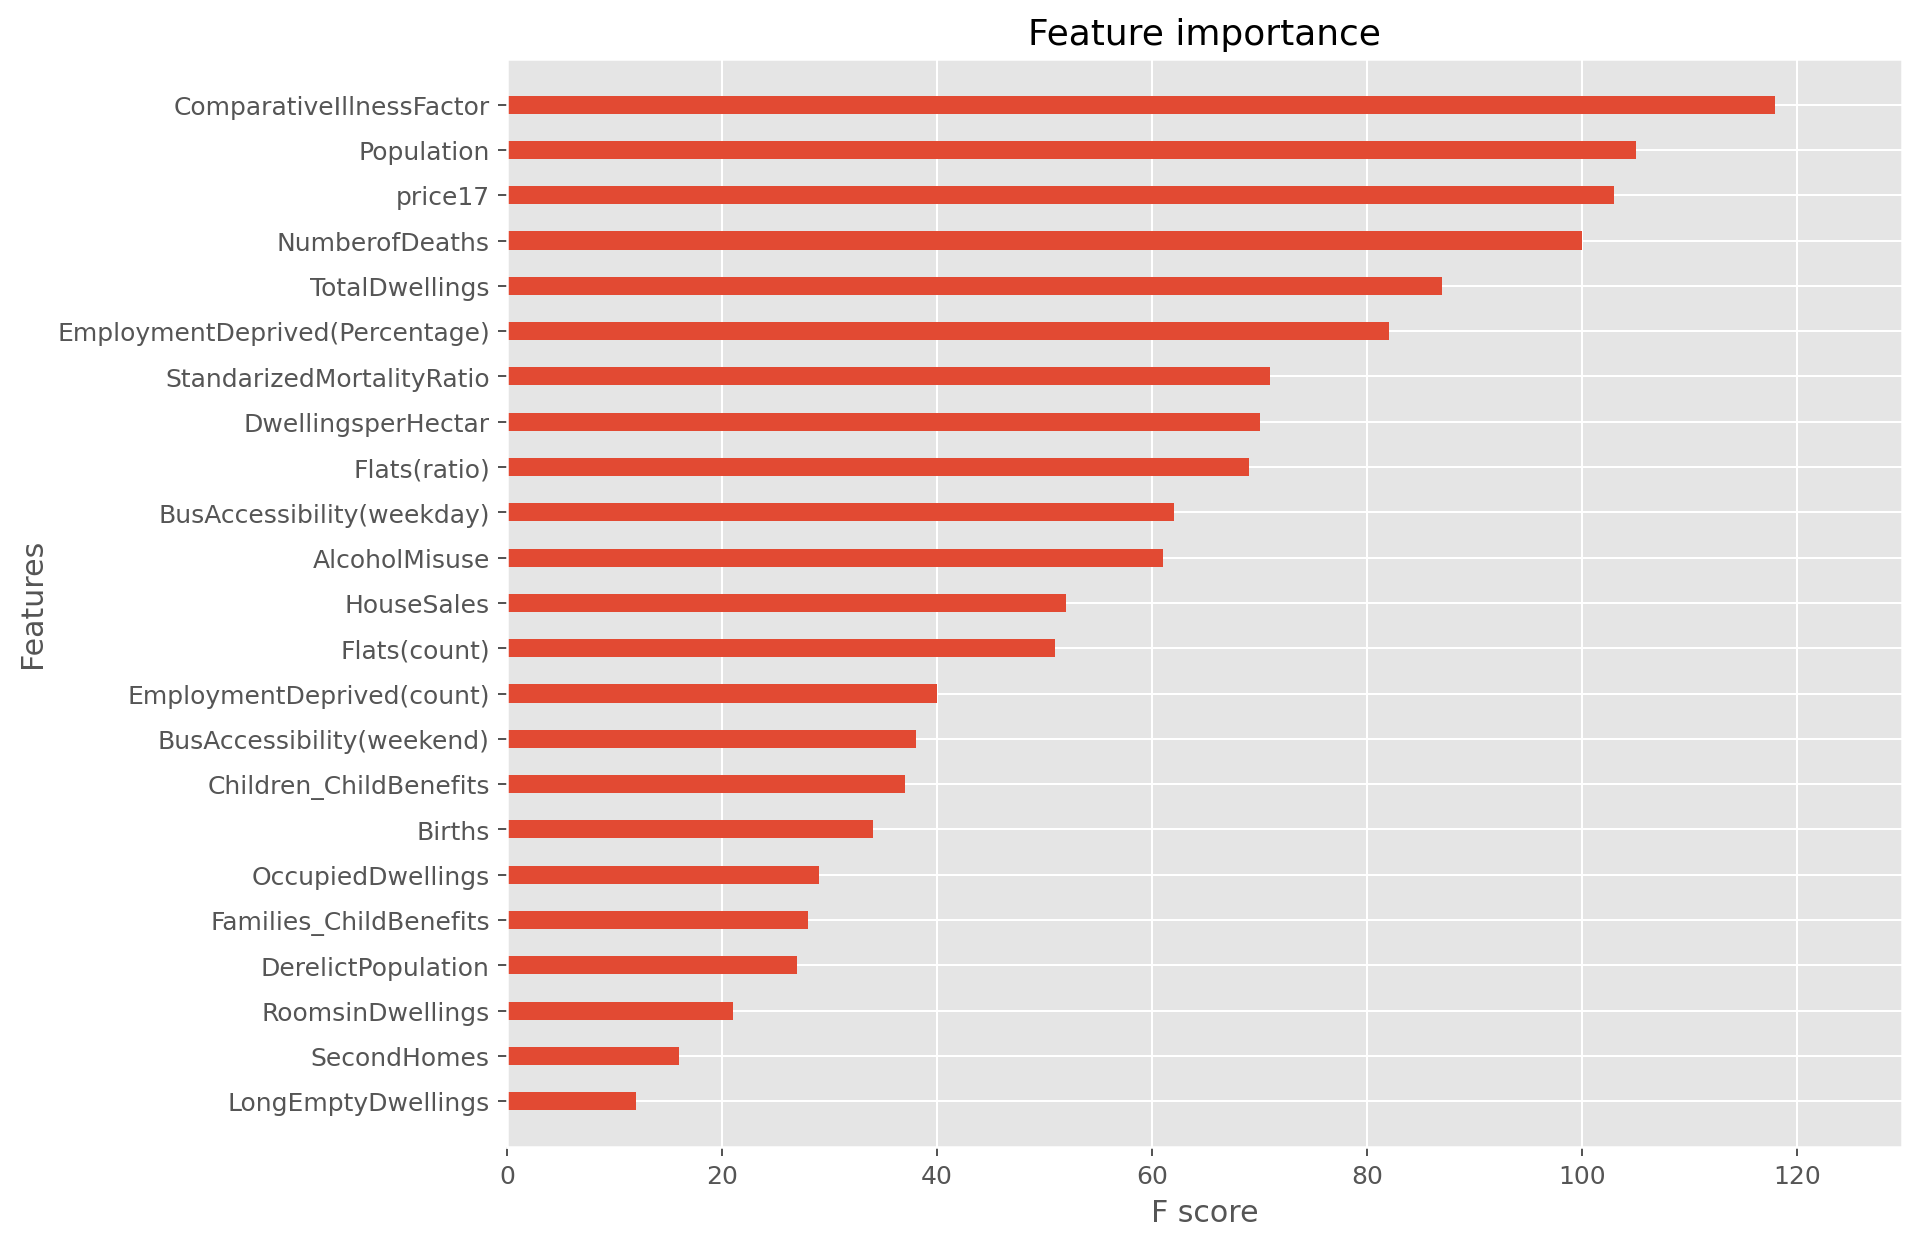

In [ ]:
from matplotlib import pyplot
%matplotlib inline

fig, ax = pyplot.subplots(figsize=(10, 8), dpi=180)


xgb.plot_importance(best, height=0.4, max_num_features=30, show_values=False, ax=ax)

pyplot.show()

How is importance calculated? Here's an excerpt from the [documentation](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.plotting):

> **importance_type (str, default "weight") –**
> How the importance is calculated: either “weight”, “gain”, or “cover”
> - ”weight” is the number of times a feature appears in a tree
> - ”gain” is the average gain of splits which use the feature
> - ”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

We'll focus on the first two. Gain is a way to quantify how much a feature contributes to improving accuracy. Let's try out `gain` to see how it differs from `weight`.

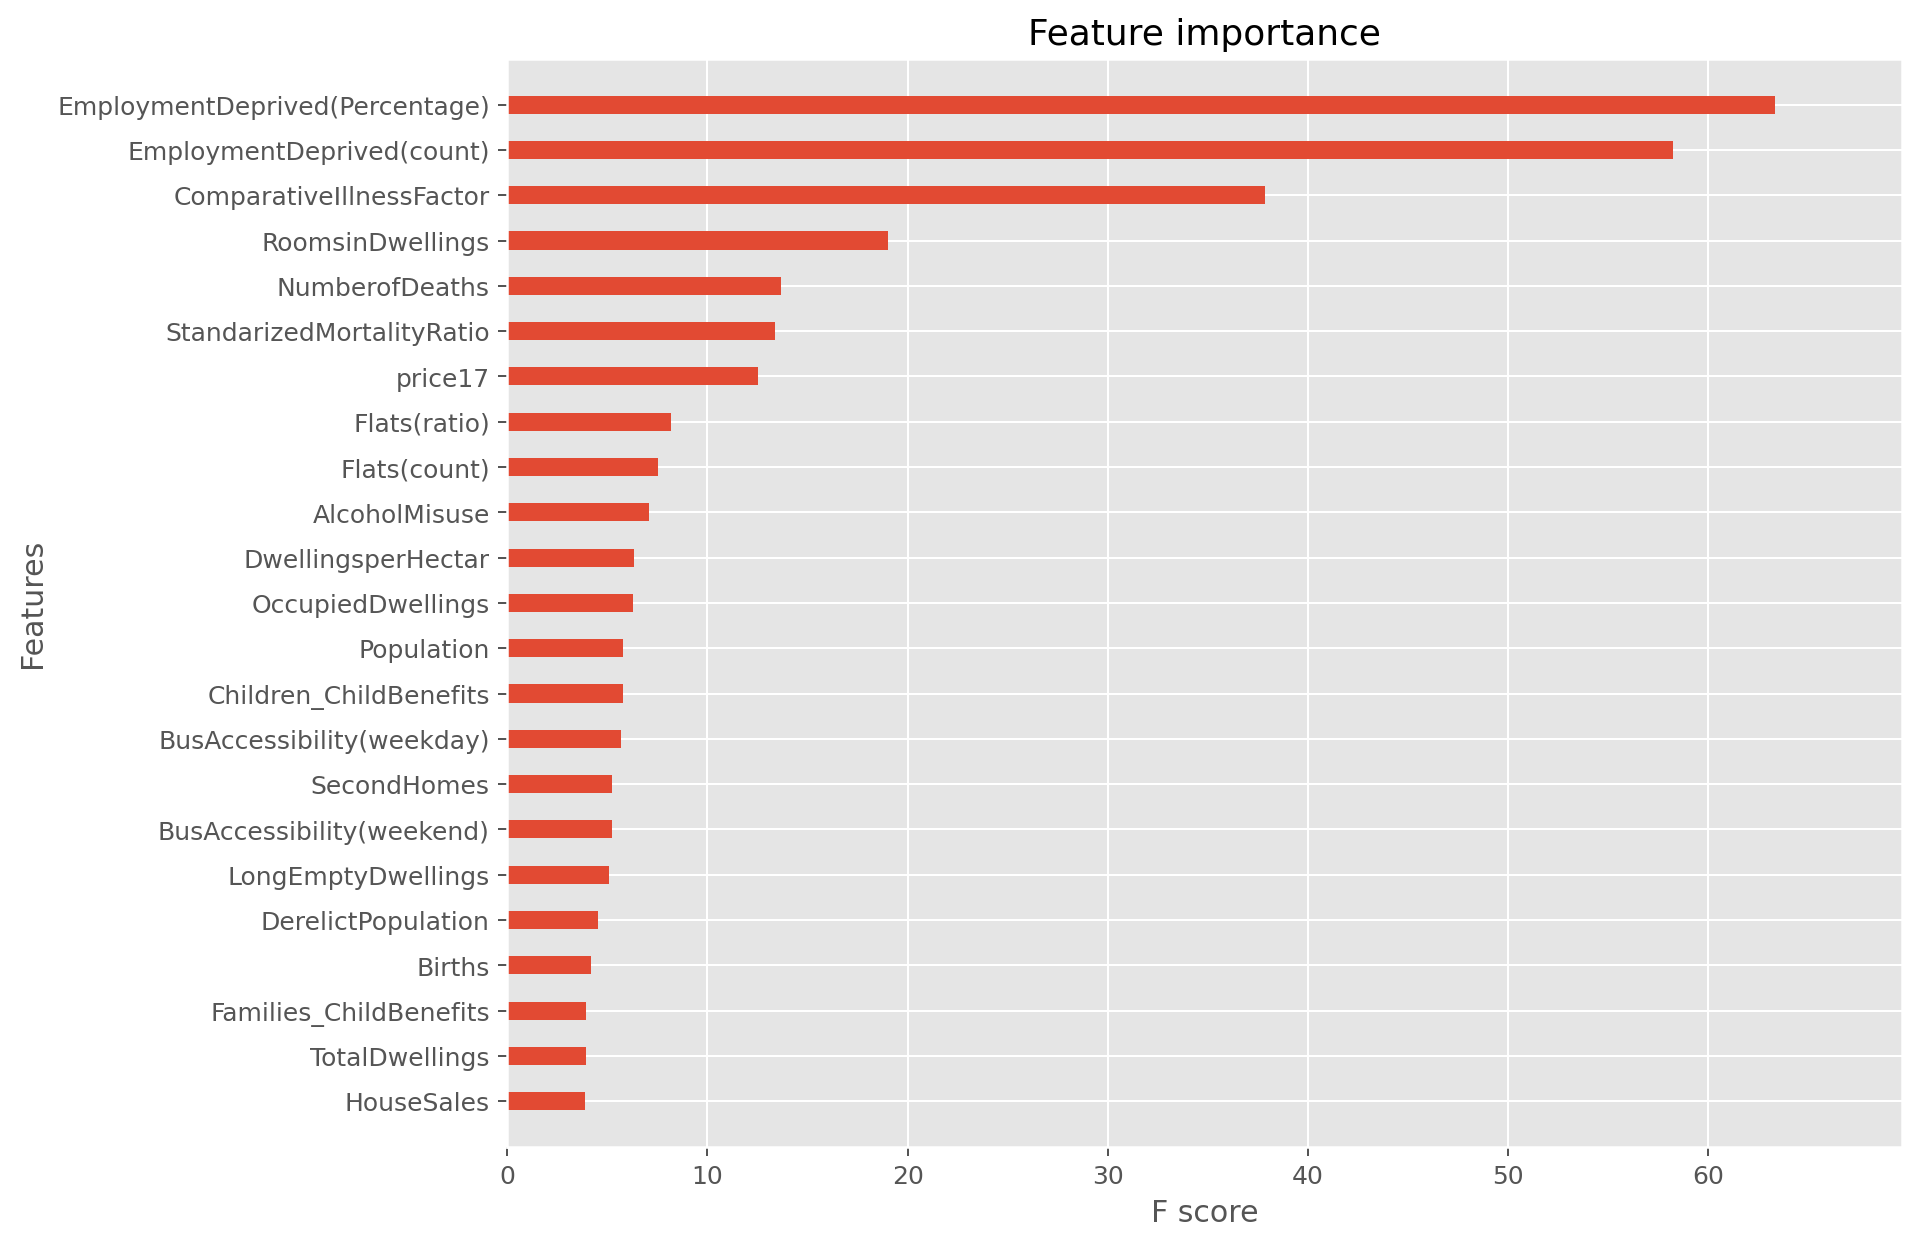

In [ ]:
from matplotlib import pyplot
%matplotlib inline

fig, ax = pyplot.subplots(figsize=(10, 8), dpi=180)


xgb.plot_importance(best, height=0.4, importance_type='gain', max_num_features=30, show_values=False, ax=ax)

pyplot.show()

Here we see the ordering of features differs quite a bit between `gain` and `weight`! This implies that (1) feature importance can be subjective, and (2) the number of appearances a feature has on a tree is not necessarily correlated to how much gain it brings. For example, a binary variable has less of a chance to appear as many times as a continuous variable on a tree, since there are only two outputs. However, it can still be a powerful feature.

#### **Plotting a decision tree from your model**

The second handy visualization function is `plot_tree()` which visually generates a decision tree in your model. Remember, there are multiple trees in the model.

It takes in the fitted XGBoost model, and with the `num_trees` parameter, you can indicate which tree you want to see. For example, if I have `n_estimator=3`, I can set the `num_trees` parameter as `0`, `1`, or `2` to see the first, second, or third tree, respectively.

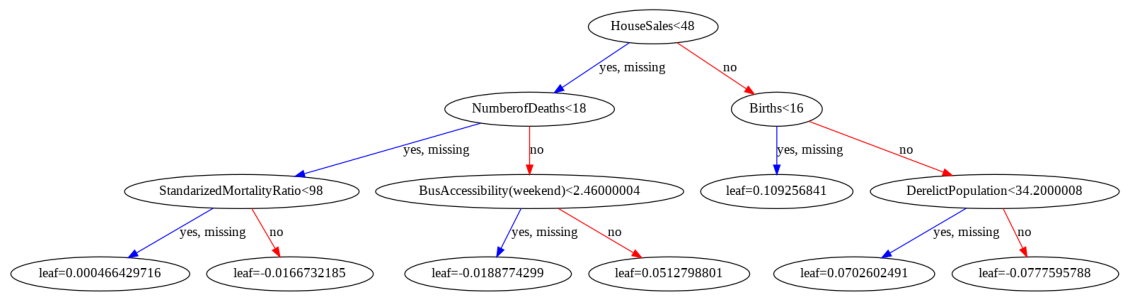

In [ ]:
matplotlib.rcParams['figure.figsize'] = (20.0, 8)

# Plot the first tree
xgb.plot_tree(best, num_trees=149)

The leaf output is the raw score. It's converted to a probability at the end of training.

## **5. Local Explainability of the Model**

Various approaches have been proposed for explaining model predictions varying in scope and flexibility. The scope indicates whether the method generates global explanations or local explanations, whereas the flexibility indicates whether the approach is model-specific or model-agnostic. Local explanations reveal the impact of input features on individual predictions of a single sample. Although SHAP is a local explainability model, it introduces global interpretation methods based on aggregations of Shapley values. 

In [ ]:
explainer = shap.TreeExplainer(best)

In [ ]:
# Compute the shapley values
shap_values = explainer.shap_values(X)
shap_values_slice = explainer(X[:1000])
features_display = X.loc[X.index]
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]

The SHAP summary plot is presented in the form of a set of beeswarm plots. The order of the features reflects their importance, i.e., the sum of the SHAP value magnitudes across all samples. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high.

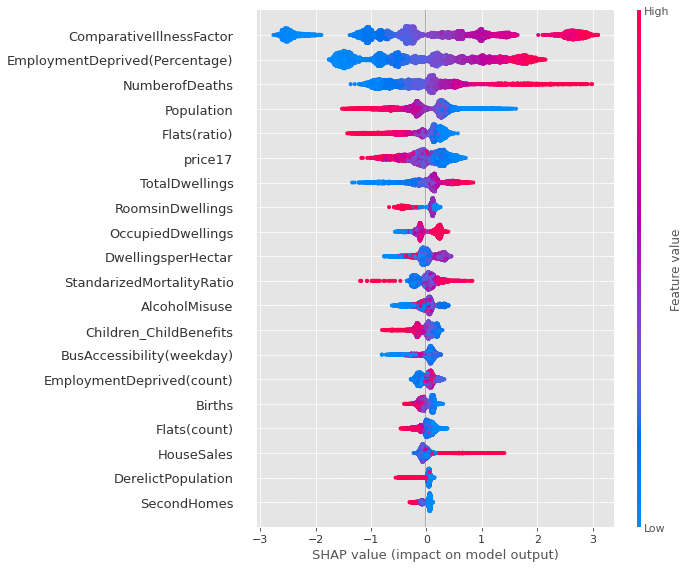

In [ ]:
%matplotlib inline
shap.summary_plot(shap_values, X)

The plot reveals that the Comparative Illness Factor (CIF) is the most important feature globally. CIF is a measure of chronic health conditions that takes account of people from all ages. CIF greater than 100 indicates poorer health conditions relative to Scotland and vice-versa. The plot indicates the direction of the effects, meaning, for example, that low CIF data zones (blue) have higher probablity of having expensive houses than high CIF data zones (red). Moreover, the plot presents the distribution of effect sizes, such as the long tails of many variables. These long tails mean that features with a low global importance can be extremely important for specific data zones. For example, although the number of house sales normally do not imply propabilty of the population being prescribed drugs for anxiety, depression or psychosis, in some abnormal cases the high number of sales indicate areas with higher anxiety, depression or psychosis.

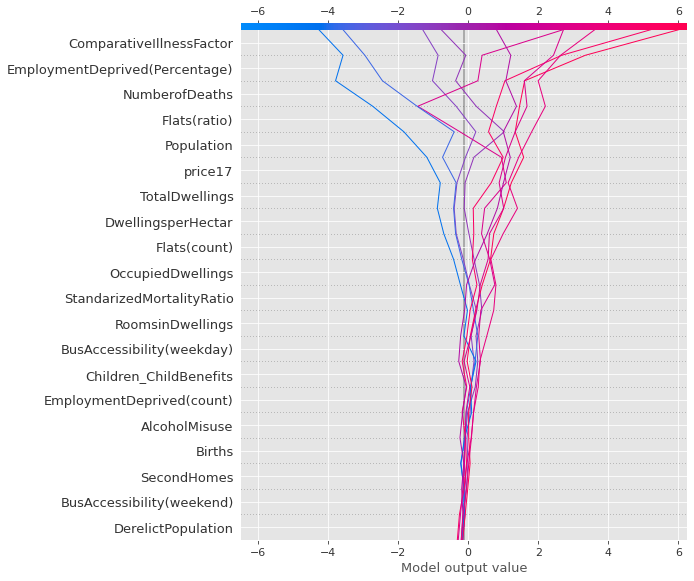

In [ ]:
# Get expected value and shap values array
expected_value = explainer.expected_value
shap_array = explainer.shap_values(X)

#Descion plot for first 10 observations
shap.decision_plot(expected_value, shap_array[0:10],feature_names=list(X.columns))

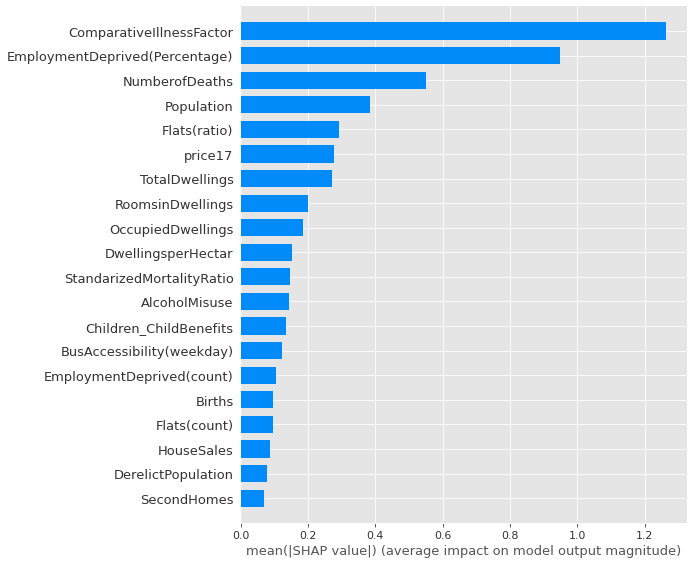

In [ ]:
%matplotlib inline
shap.summary_plot(shap_values, X, plot_type="bar")

In a force plot, variables with SHAP values that 'push' the model towards a higher price appear on the left in red, whereas those that 'push' the model towards a lower price appear on the right in blue. The actual value of the variable is shown alongside the variable name. Variables with larger SHAP values (i.e. more impact) have larger arrows. 

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0:10,:], X.iloc[0:10,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values)

Output hidden; open in https://colab.research.google.com to view.

Finally Dependence Plots allows us to visualize the relationship between a feature's values and the model's predicted outcome. For example in the plot for Comperative Illness factor a clear linear trend emerges throughout its range of values while Population Price17 are correlated negatively with their respective shap values

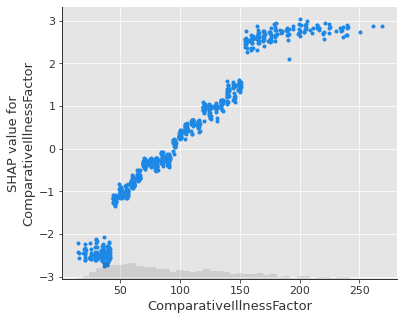

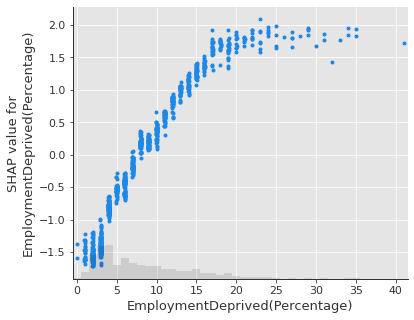

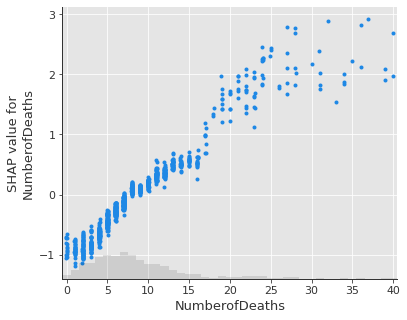

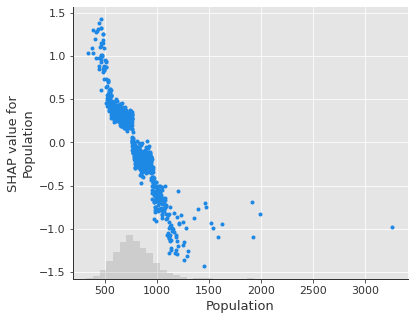

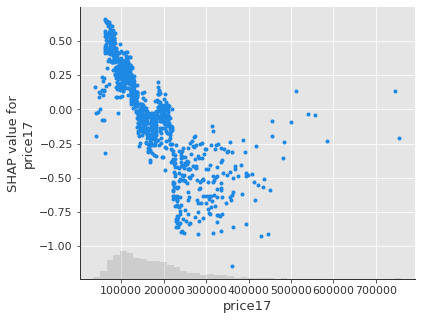

In [ ]:
for i in range(-1, -6, -1):
    shap.plots.scatter(shap_values_slice[:, shap_values_slice.abs.mean(0).argsort[i]])